In [199]:
# Librerias
import os
from bs4 import BeautifulSoup
from unidecode import unidecode
import datetime
import traceback
import json
import csv
import pandas as pd
import jellyfish
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
import re

In [200]:
# Parámetros
sourceDataFolder = "1-source-data"

bumeraniterationNumber = "5"
bumeranRootPath = sourceDataFolder + r"\main\bumeran\iteration-" + bumeraniterationNumber

intermFilesFolder = "2-intermediate-files"
mergedMainFolder = "3-results"
logsFolder = "4-logs"

dataVisualizationTopLimit = 20

counterIn = 0
counterOut = 0

In [201]:
# Funciones utilitarias
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

def parseLineBreaksAndAccents(text):
  return unidecode(" ".join(text.split()))

def parseNames(text):
  return text.strip().title()

def findTags(tag, color):
  return tag.find("span", {"style": 'font-size:10.0pt;font-family:"Arial",sans-serif;mso-fareast-font-family:\n"Times New Roman";color:' + color })

def getChildIndex(mainChildTags, title, color):
  return next((index for index, tag in enumerate(mainChildTags) if ( findTags(tag, color).text == title if findTags(tag, color) else False )), None)

def getSectionsIndexes(mainChildTags, color):
  sectionsIndexes = []
  sectionsTitle = ["Experiencia laboral", "Educación", "Informática", "Idiomas", "Otros Conocimientos"]
  
  for sectionTitle in sectionsTitle:
    sectionIndex = getChildIndex(mainChildTags, sectionTitle, color)
    sectionsIndexes.append(sectionIndex)
  
  sectionsIndexes.append(len(mainChildTags)-1)
  return sectionsIndexes

def getNextSectionIndexValid(sectionsIndexes, i):
  while(not sectionsIndexes[i]):
    i = i + 1

  return sectionsIndexes[i]

def getStartAndEndIndex(sectionsIndexes, i):
  return sectionsIndexes[i], getNextSectionIndexValid(sectionsIndexes, i+1)

def readJson(path, encoding='utf-8', errors=None):
  with open (path, "r", encoding=encoding, errors=errors) as f:
    data = json.loads(f.read())
  return data

def writeJson(data, pathJson, encoding='utf-8'):
  with open(pathJson, 'w', encoding=encoding) as f:
    json.dump(data, f, indent=4, ensure_ascii=False)

def writeCsv(data, pathCsv, encoding='utf-8'):
  with open(pathCsv, 'w', newline='', encoding=encoding) as f:
    if data:
      writer = csv.DictWriter(f, fieldnames=data[0].keys(), lineterminator='\n')
      writer.writeheader()
      writer.writerows(data)
    else:
      f.write("")

def writeTxt(data, pathTxt, encoding='utf-8'):
  with open(pathTxt, 'w', encoding=encoding) as f:
    f.write(data)

In [202]:
# Funciones principales
def getFiles(rootPath, source):
  # Obteniendo todas las carpetas de los perfiles
  folders = [f for f in os.listdir(rootPath) if os.path.isdir(os.path.join(rootPath, f))]

  # Definiendo la lista de archivos final
  files = []

  # Iterando sobre las carpetas
  for folder in folders:
    # Obteniendo los archivos por cada carpeta
    folderFiles = [os.path.join(rootPath, folder, f) for f in os.listdir(os.path.join(rootPath, folder)) if os.path.isfile(os.path.join(rootPath, folder, f))]

    # Agregando esos archivos a la lista de archivos final
    if folderFiles:
      files.extend(folderFiles)

  print("Archivos originales: " + str(len(files)))

  # Filtros específicos por cada origen
  if source == "bumeran":
    filesFiltered = [f for f in files if ("\Has recibido un CV para el aviso" in f)]
  else:
    filesFiltered = files

  print("Archivos filtrados solo con postulaciones: " + str(len(filesFiltered)))

  # Filtros para considerar un archivo especifico
  filterIsIn = [
    #r"1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(76).html"
    #r"1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(110).html"
    #r"1-source-data\main\linkedin\iteration-2\bandeja-entrada\New application_ .NET Developer from Cesar Ospino.html"
    #r"1-source-data\main\bumeran\iteration-4\a-considerar\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(1).html"
    #r"1-source-data\main\bumeran\iteration-4\a-considerar\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_.html"
    #r"1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad Sr. (Test Lead)_(1).html"
    #r"1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(1).html"
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador Senior_Full Stack_(2).html"
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(6).html"
    #r"1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net Senior_(4).html"
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas_(24).html"
    # 5 casos con estudios en blanco
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica Jr_(50).html",
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(132).html",
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(173).html",
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(71).html",
    #r"1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial TI_(38).html"
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(196).html"
  ]
  filesFilteredIsIn = [f for f in filesFiltered if ( f in filterIsIn if filterIsIn else True )]

  # Filtros para omitir un archivo especifico
  filterIsNotIn = [
    # 3 archivos con data incompleta (se mantiene en iteracion 4 y 5)
    r"1-source-data\main\bumeran\iteration-5\bandeja-entrada-2022\Has recibido un CV para el aviso _Analista Programador Senior_Full Stack_(2).html",
    r"1-source-data\main\bumeran\iteration-5\bandeja-entrada-2022\Has recibido un CV para el aviso _Analista Programador_(6).html",
    r"1-source-data\main\bumeran\iteration-5\programador-net\Has recibido un CV para el aviso _Programador .Net Senior_(4).html",
  ]

  filesFilteredNotIn = [f for f in filesFilteredIsIn if ( f not in filterIsNotIn if filterIsNotIn else True )]

  print("Archivos filtrados solo con data completa: " + str(len(filesFilteredNotIn)))

  # Limites superiores e inferiores en la búsqueda de archivos
  startLimit = None
  topLimit = None
  filesFilteredLimits = filesFilteredNotIn[(startLimit-1 if startLimit else 0): (topLimit if topLimit else len(files))]

  return filesFilteredLimits

In [203]:
def getEncodingBumeran(file, stringLog):
  encoding = "windows-1252"
  try:
    with open(file, "r", encoding="utf-16-le") as f:
      if "charset=unicode" in f.read():
        encoding = 'utf-16-le'
      else:
        raise Exception
  except Exception as e:
    try:
      with open(file, "r", encoding="windows-1252") as f:
        if "charset=windows-1252" in f.read():
          encoding = 'windows-1252'
        else:
          encoding = encoding
    except Exception as e:
      print(file)
      stringLog = stringLog + file + "\n"
      traceback.print_exc()
      stringLog = stringLog + traceback.format_exc() + "\n"
      print()
      stringLog = stringLog + "\n"
      pass
      
  return encoding, stringLog

In [204]:
def getCandidateBumeran(file, encoding, stringLog):
  candidateData = {}
 
  try:
  # Abriendo el archivo
    with open(file, "r", encoding=encoding) as myFile:
      #Parseando el archivo html a soup
      soup = BeautifulSoup(myFile.read(), "lxml")

      # Obteniendo cada uno de los campos para la data

      # Fecha de postulación
      spanDates = soup.find_all("span", {"style": "color:black"})
      if len(spanDates) > 4:
        rawPostulationDate = spanDates[3].text
        postulationDate = datetime.datetime.strptime(spanDates[3].text, "%A, %B %d, %Y %I:%M %p")
      else:
        spanDates2 = soup.find_all("span", {"style": 'font-family:"Calibri",sans-serif;color:black'})
        rawPostulationDate = spanDates2[3].text
        postulationDate = datetime.datetime.strptime(spanDates2[3].text, "%A, %B %d, %Y %I:%M %p")
        
      candidateData["candidatePostulationDate"] = postulationDate.strftime("%Y-%m-%d %H:%M")

      # Definiendo los colores a usar para las búsquedas según las fechas
      # En la fecha 2020-06-11 cambio el color de los titulos de cada sección
      inflexionDate = datetime.datetime(2020,6,11,12,5,0)
      colorTitle, colorSections = ("#008599", "#2192C9") if postulationDate <= inflexionDate else ("#E90066", "#0A26EE")

      # Nombre del perfil
      #candidateData["jobProfileName"] = parseNames(parseLineBreaksAndAccents(soup.findAll("span", {"style": ("color:" + colorTitle) })[0].text))

      liTags = soup.find_all("ul", {"type": "disc"})[0].find_all("li")

      # Nombre del candidato
      firstLinePased = parseNames(parseLineBreaksAndAccents(liTags[0].text))
      candidateData["candidateFullName"] = firstLinePased
      
      """
      expectedCivilStatusValues = ["Soltero/A", "Casado/A", "Divorciado/A", "Pareja De Hecho", "Viudo/A", "Union Libre"]
      secondLineParsed = parseNames(parseLineBreaksAndAccents(liTags[1].text))
      candidateData["secondLineParsed"] = secondLineParsed
      
      # Pais de residencia
      firstcommaIndex = secondLineParsed.find(",")
      if firstcommaIndex != -1:
        candidateData["candidateResidenceCountry"] = secondLineParsed[:firstcommaIndex]
      else:
        candidateData["candidateResidenceCountry"] = ""

      # Estado civil
      civilStatus = ""
      for value in expectedCivilStatusValues:
        if value in secondLineParsed:
          civilStatus = value
      candidateData["candidateCivilStatus"] = civilStatus

      # Numero de documento
      # Propiedad especial del rfind, el -1 coincide con el inicio del string, por lo que es lo mismo tomarlo con o sin el indice, en caso el index no sea -1
      lastSpaceIndex = secondLineParsed.rfind(" ")
      candidateData["candidateDocumentNumber"] = re.sub("[^0-9]", "", secondLineParsed[lastSpaceIndex+1:]) """

      """# Fecha de nacimiento
      thirdLineParsed = parseNames(parseLineBreaksAndAccents(liTags[2].text))
      birthDate = thirdLineParsed[thirdLineParsed.find(":")+2:]
      if birthDate != "":
        candidateData["candidateBirthDate"] = datetime.datetime.strptime(thirdLineParsed[thirdLineParsed.find(":")+2:], "%d-%m-%Y").strftime("%Y-%m-%d")
      else:
        candidateData["candidateBirthDate"] = """""

      # Pais de nacimiento
      fourthLineParsed = parseNames(parseLineBreaksAndAccents(liTags[3].text))
      candidateData["candidateBirthCountry"] = fourthLineParsed[fourthLineParsed.find(":")+2:]
      
      # Nombre del postulante
      """rawcandidateName = [0].find_all("span")[0].text # El split join tambien quita saltos de línea
      candidateData["candidateName"] = parseNames(parseLineBreaksAndAccents(rawcandidateName))

      candidateData["contactData"] = str(soup.find_all("ul", {"type": "disc"})[0])"""

      # Pais de residencia
      """tagResidenceCountry = soup.find_all("ul", {"type": "disc"})[0].find_all("span")
      if len(tagResidenceCountry) > 2:
        if tagResidenceCountry[2].text.find(",") != -1:
          residenceCountry = parseNames(parseLineBreaksAndAccents(tagResidenceCountry[2].text[0:tagResidenceCountry[2].text.find(",")]))
          candidateData["residenceCountry"] = residenceCountry
          if residenceCountry == "":
            raise Exception("Error no mapeado 3")
        else:
          raise Exception("Error no mapeado 2")
      else:
        raise Exception("Error no mapeado 1 (posiblemente data incompleta como los 3 casos)")
      
      
      mainDivTag = soup.find_all("div", {"style": 'background-position-x:50%;background-position-y:100%'})[0]
      mainChildTags = mainDivTag.find_all(recursive=False)

      sectionsIndexes = getSectionsIndexes(mainChildTags, colorSections)
      
      # Experiencia laboral
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 0)

      if startIndex and endIndex:
        workExperienceTags = mainChildTags[startIndex+2:endIndex]
        candidateData["lastWorkCenter"] = parseNames(parseLineBreaksAndAccents(workExperienceTags[0].find_all("b")[0].text))
        candidateData["lastWorkPosition"] = parseNames(parseLineBreaksAndAccents(workExperienceTags[1].find_all("b")[0].text))

        daysOfExperience = 0
        for index in range(0, len(workExperienceTags), 2):
          startDate = datetime.datetime.strptime(parseLineBreaksAndAccents(workExperienceTags[index].text)[0: parseLineBreaksAndAccents(workExperienceTags[index].text).find(" - ")] , "%d-%m-%Y")
          endDateText = parseLineBreaksAndAccents(workExperienceTags[index].text)[parseLineBreaksAndAccents(workExperienceTags[index].text).find(" - ")+3: parseLineBreaksAndAccents(workExperienceTags[index].text).find(" | ")]
          endDate = datetime.datetime.strptime(endDateText, "%d-%m-%Y") if endDateText != "Presente" else datetime.datetime.strptime(rawPostulationDate, "%A, %B %d, %Y %I:%M %p")
          daysOfExperience = daysOfExperience + (endDate - startDate).days
        candidateData["yearsOfExperience"] = int(daysOfExperience/365)
        candidateData["worksNumber"] = int(len(workExperienceTags)/2)

        if (candidateData["lastWorkCenter"] == "" or candidateData["lastWorkPosition"] == ""):
          raise Exception("Error no mapeado (experiencia laboral)")
      else:
        raise Exception("561 errores mapeados (experiencia laboral)")
      
      
      # Carrera profesional (última alcanzada)
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 1)

      if startIndex and endIndex:
        educationTags = mainChildTags[startIndex+2:endIndex]
        
        careerTags0 = educationTags[0].find_all("b")
        candidateData["studyCenter"] = parseNames(parseLineBreaksAndAccents(careerTags0[0].text))
        candidateData["careerField"] = parseNames(parseLineBreaksAndAccents(careerTags0[1].text))

        careerTags1 = educationTags[1].find_all("span")
        tempText = careerTags1[len(careerTags1)-2].text
        candidateData["careerStatus"] = parseNames(parseLineBreaksAndAccents(tempText[tempText.find(",")+2:tempText.rfind(",")]))
        candidateData["careerDegree"] = parseNames(parseLineBreaksAndAccents(tempText[tempText.rfind(",")+2:tempText.rfind(".")]))
        candidateData["studiesNumber"] = int(len(educationTags)/2)

        if (candidateData["studyCenter"] == "" or candidateData["careerField"] == "" or candidateData["careerStatus"] == "" or candidateData["careerDegree"] == ""):
          raise Exception("Error no mapeado (educación)")
      else:
        raise Exception("121 errores mapeados (educación)")

      
      # Habilidades técnicas
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 2)

      if startIndex and endIndex:
        # Falta mejorar la validación (algunos tienen solo u, solo carrera o ninguno)
        technicalSkillsTags = mainChildTags[startIndex+2:endIndex][0].find_all("span")
        candidateData["technicalSkills"] = int(len(technicalSkillsTags)/4)
      else:
        raise Exception("Errores no mapeados (habilidades técnicas)")

      # Lenguajes
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 3)

      if startIndex and endIndex:
        # Falta mejorar la validación (algunos tienen solo u, solo carrera o ninguno)
        languagesTags = mainChildTags[startIndex+2:endIndex][0].find_all("span")
        candidateData["languages"] = int(len(languagesTags)/7)
      else:
        raise Exception("Errores no mapeados (lenguajes)")

      # Otros conocimientos (habilidades blandas)
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 4)

      if startIndex and endIndex:
        # Falta mejorar la validación (algunos tienen solo u, solo carrera o ninguno)
        otherKnowledgesTags = mainChildTags[startIndex+2:endIndex][0].find_all("span")
        candidateData["anotherSkills"] = int(len(otherKnowledgesTags)/3)
      else:
        raise Exception("Errores no mapeados (otras habilidades)")

      # Pendiente de analizar casos fraccionarios (se trunco para caso práctico)

      # Salario pretendido
      tagsSalary = [index for index, tag in enumerate(soup.find_all("span")) if "Sueldo pretendido" in tag.text]
      if len(tagsSalary) > 0:
        rawSalary = soup.find_all("span")[tagsSalary[0]+1].text
        candidateData["salary"] = int(rawSalary[rawSalary.find("$")+1:rawSalary.find(".")])
      else:
        raise Exception("Errores no mapeados (salario)")
        """

  except Exception as e:
    candidateData = {}
    #print(file)
    stringLog = stringLog + str(file) + "\n"
    #print(traceback.format_exc())
    stringLog = stringLog + traceback.format_exc() + "\n"
    #print()
    stringLog = stringLog + "\n"
    pass

  return candidateData, stringLog

In [205]:
def iterateFiles(files, source):
  # Definiendo el log de errores
  stringLog = ""

  # Definiendo la data final de candidatos
  data = []
  
  # Iterando por cada archivo
  for index, file in enumerate(files):
    if (index % 250 == 0):
      print(str(index) + "/" + str(len(files)) + " archivos analizados")

    # Obteniendo el encoding por cada archivo
    encoding, stringLog = getEncodingBumeran(file, stringLog)

    # Obteniendo los datos por cada archivo
    candidate, stringLog = getCandidateBumeran(file, encoding, stringLog)
    
    # Añadiendo los datos del candidato a la data final
    if (candidate):
      data.append(candidate)

  # Realizando un ordenamiento por fecha de postulación, en orden descendente
  sortedData = sorted(data, key=lambda x: (x["candidatePostulationDate"]), reverse=True)

  return data, stringLog

In [206]:
def readAndWriteMain(source):
  # Definiendo la carpeta raiz de los archivos a buscar, según el origen
  rootPath = bumeranRootPath

  # Obteniendo la lista de archivos, según el origen
  files = getFiles(rootPath, source)

  # Iterando sobre los archivos, calculando la data y el log de error
  data, stringLog = iterateFiles(files, source)

  # Escribiendo la data de los candidatos (json y csv)
  writeJson(data, os.path.join(intermFilesFolder, source + '.json'))
  writeCsv(data, os.path.join(intermFilesFolder, source + '.csv'))

  # Escribiendo el log de errores
  writeTxt(stringLog, os.path.join(logsFolder, source, datetime.datetime.now().strftime("%Y-%m-%d %H-%M-%S") + ".txt"), 'utf-16')

  return data

In [207]:
def readAndWriteMergedMain(mainData):
  mergedMainData = []
  for elem in mainData:
    if (elem):
      mergedMainData.extend(elem)

  writeJson(mergedMainData, os.path.join(mergedMainFolder, "result.json"), 'utf-8')
  writeCsv(mergedMainData, os.path.join(mergedMainFolder, "result.csv"), 'utf-8')

  return mergedMainData

In [208]:
def visualizeData(mergedMainData):
  df = pd.DataFrame(mergedMainData)

  print(df.count())

  columns = [elem for elem in df.columns if elem not in ["candidatePostulationDate", "candidateFullName"]]

  for column in columns:
    top10 = df[column].value_counts()[:dataVisualizationTopLimit]
    print(top10)
    y_axis = list(reversed(top10.index))
    x_axis = list(reversed(top10.values))
    plt.ylabel(column)
    plt.barh(y_axis, x_axis)
    plt.show()

Inicio: 2023-05-16 02:22:18.665825
Se inició el procesamiento
Archivos originales: 10230
Archivos filtrados solo con postulaciones: 10228
Archivos filtrados solo con data completa: 10225
0/10225 archivos analizados
250/10225 archivos analizados
500/10225 archivos analizados
750/10225 archivos analizados
1000/10225 archivos analizados
1250/10225 archivos analizados
1500/10225 archivos analizados
1750/10225 archivos analizados
2000/10225 archivos analizados
2250/10225 archivos analizados
2500/10225 archivos analizados
2750/10225 archivos analizados
3000/10225 archivos analizados
3250/10225 archivos analizados
3500/10225 archivos analizados
3750/10225 archivos analizados
4000/10225 archivos analizados
4250/10225 archivos analizados
4500/10225 archivos analizados
4750/10225 archivos analizados
5000/10225 archivos analizados
5250/10225 archivos analizados
5500/10225 archivos analizados
5750/10225 archivos analizados
6000/10225 archivos analizados
6250/10225 archivos analizados
6500/10225 ar

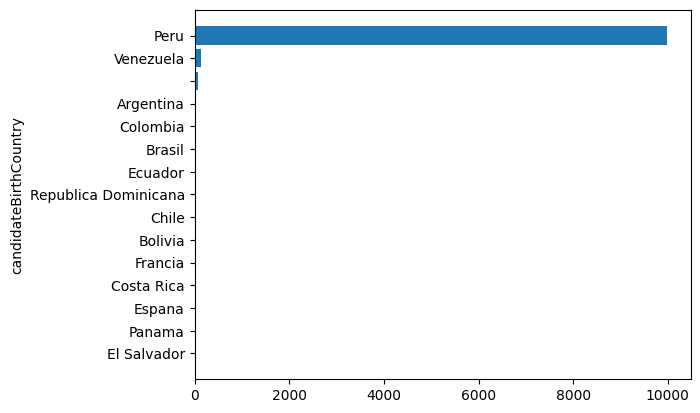

Fin: 2023-05-16 02:23:33.672140
Tiempo: 0:01:15.006315


In [209]:
def main():
  # Definiendo el inicio del proceso
  startTime = datetime.datetime.now()
  print("Inicio: " + str(startTime))
  print("Se inició el procesamiento")

  # El dataset principal que sea el de bumeran
  # Los otros archivos que solo se usen para actualizar la variable objetivo
  # Esto porque los otros orígenes están incompletos y costaría llenar los campos (incluso el excel que se hizo)
  isLoadedBumeran = False
  isMergedMain = False
  #False

  # Leyendo o calculando bumeran
  bumeranData = readJson(os.path.join(intermFilesFolder, 'bumeran.json')) if isLoadedBumeran else readAndWriteMain('bumeran')
  print("Se terminó de procesar Bumeran")

  # Uniendo la data principal (bumeran + linkedin (ya no))
  mergedMainData = readJson(os.path.join(mergedMainFolder, 'result.json')) if isMergedMain else readAndWriteMergedMain([bumeranData])
  print("Se terminó de unir la data principal")

  visualizeData(mergedMainData)
  
  # Definiendo el fin del proceso
  endTime = datetime.datetime.now()
  print("Fin: " + str(endTime))
  print("Tiempo: " + str(endTime-startTime))

  #print(counterIn)
  #print(counterOut)

if __name__ == "__main__":
  main()